In [1]:
import os
import time

import umap
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import multiMACA as maca

from scipy import io
from scipy.sparse import csr_matrix

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
##plot function
def plot_ann_umap(ad=None,ann=None):
    cluster_names = {}
    code, uniques = pd.factorize(ann)
    ad.obs['groups']=code.astype(str)
    for i in range(len(uniques)):
        cluster_names[str(i)]=str(i)+": "+uniques[i]

    ad.obs['Annotation'] = ad.obs['groups'].apply(lambda s: cluster_names[s])
    plt.figure(figsize=(8, 8))
    sc.pl.embedding(ad, basis='umap', color='Annotation', ax=plt.gca(), 
                    show=False)#, alpha=0.01#, size=10)

    df = pd.DataFrame(ad.obsm['X_umap'])
    df['cluster'] = ad.obs['groups'].values
    mean_pos = df.groupby('cluster').median()

    for c in mean_pos.index:    
        plt.gca().text(mean_pos.loc[c][0], mean_pos.loc[c][1], c.split(':')[0], 
                       fontsize=16, color='black')

    plt.title('Annotation')
    plt.show()

In [3]:
cell_markers={}

##Add PanglaoDB celltypes and markers
##Use PanglaoDB as marker database
##PanglaoDB available at https://panglaodb.se/index.html
pg_df = pd.read_table("MACA/PanglaoDB_markers_27_Mar_2020.tsv")
##remove mouse specific genes
pg_df = pg_df[pg_df['species']!='Mm']
for i in list(set(pg_df["cell type"].values.tolist())):
    genes = pg_df[pg_df["cell type"]==i]['official gene symbol'].values.tolist()
    ##only use cell type with at least 5 genes and less than 300 genes
    if len(genes)>=5 and len(genes)<=300:
        cell_markers[i]=genes


##human lung atlas markers (Travaglini et al., Nature 2020)
#markers_xls = pd.ExcelFile('Downloads/Atlas_markers/Lung/41586_2020_2922_MOESM6_ESM.xlsx')

#for cluster in markers_xls.sheet_names:
#    if 'SS2' not in cluster and 'SS' not in cluster:
#        markers = pd.read_excel(markers_xls, cluster,header=None,index_col=False)
#        celltype = markers.iloc[0,0]
#        markers = pd.read_excel(markers_xls, cluster,header=1,index_col=0)
#        markers = markers[markers['avg_logFC'].values>=1]
#        markers = markers[markers['pct_in_cluster'].values>=0.8]
#        markers = markers[markers['pct_out_cluster'].values<0.5]
#        markers = markers.index.tolist()
#        if len(markers)>=5 and len(markers)<=300:
#            cell_markers[celltype]=markers
        
###human kidney atlas markers (Stewart et al., Science 2019)
#markers_dir = "Downloads/Atlas_markers/Kidney/"
#files = os.listdir(markers_dir)

#for f in files:
#    markers = pd.read_csv(markers_dir+f,index_col=0, header=1)
#    logFold = np.log((markers['geneExpression'].values+1)/(markers['geneExpressionOutsideCluster'].values+1))
#    markers = markers[logFold>=1]
#    markers = markers[markers['geneFrequency'].values>=0.8]
#    markers = markers[markers['geneFrequencyOutsideCluster'].values<0.5]
#    celltypes = markers['Cell.type'].values.tolist()
#    celltypes = list(set(celltypes))
#    for c in celltypes:
#        sub_markers = markers[markers['Cell.type'].values==c]
#        m = sub_markers['Gene'].values.tolist()
#        if len(m)>=5 and len(m)<=300:
#            cell_markers[c]=m

In [4]:
##https://www.heartcellatlas.org/
h4c_file = "global.h5ad"
adata = sc.read_h5ad(h4c_file)
adata = adata[adata.obs['source']=='Nuclei']

#https://singlecell.broadinstitute.org/single_cell/study/SCP498/transcriptional-and-cellular-diversity-of-the-human-heart
h4c_file   = "H4C_LV50_louvain1.0_V1.h5ad"
adata2 = sc.read_h5ad(h4c_file)
sc.pp.normalize_total(adata2, target_sum=1e4)##tucker
sc.pp.log1p(adata2)#tucker

##unify cell type names from these two sources
cells = adata.obs['cell_type'].values.tolist()
cells2= adata2.obs['Cluster'].values.tolist()
cells2 = np.array(cells2)

cells2[np.logical_or(np.logical_or(adata2.obs['Cluster']=='03. Atrial Cardiomyocyte',
                              adata2.obs['Cluster']=='04. Ventricular Cardiomyocyte I'),
                                np.logical_or(adata2.obs['Cluster']=='05. Cytoplasmic Cardiomyocyte I',
                                              adata2.obs['Cluster']=='06. Ventricular Cardiomyocyte II'))]='cmc'
cells2[np.logical_or(adata2.obs['Cluster']=='15. Ventricular Cardiomyocyte III',
                adata2.obs['Cluster']=='12. Cytoplasmic Cardiomyocyte II')]='cmc'

cells2[np.logical_or(np.logical_or(adata2.obs['Cluster']=='01. Fibroblast I',
                              adata2.obs['Cluster']=='02. Fibroblast II'),
                                adata2.obs['Cluster']=='14. Fibroblast III')]='fb'

cells2[np.logical_or(adata2.obs['Cluster']=='09. Endothelium I',adata2.obs['Cluster']=='10. Endothelium II')]='ec'

cells2[adata2.obs['Cluster']=='07. Pericyte']='pc'
cells2[adata2.obs['Cluster']=='13. Vascular Smooth Muscle']='smc'
cells2[adata2.obs['Cluster']=='16. Neuronal']='neuronal'
cells2[adata2.obs['Cluster']=='08. Macrophage']='myeloid'
cells2[adata2.obs['Cluster']=='17. Lymphocyte']='lymphoid'
cells2[adata2.obs['Cluster']=='11. Adipocyte']='adipocytes'

cells = cells+cells2.tolist()
cells = np.array(cells)

#batch = adata.obs['batch'].values.tolist() + adata2.obs['experiment'].values.tolist()
#source = adata.obs['source'].values.tolist()+["Nuclei_2" for i in range(len(cells2))]

var_names = adata.var_names.intersection(adata2.var_names)
data = adata[:,var_names]
adata2 = adata2[:,var_names]

In [5]:
adata = adata.concatenate(adata2)
adata.obs['CellType']=cells
marker_list = []
for k, v in cell_markers.items():
    marker_list += v
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in adata.var.index]
len(marker_list)
ad = adata[:,marker_list]

In [6]:
print(ad.X.shape)

(646921, 4289)


In [7]:
##run MACA
start_time = time.time()

##step 1 expression to cell type score
scores, labels = maca.gene2cell(ad=ad,cell_markers=cell_markers)

##step 2 clustering
label_list = maca.parallel(scores=scores,labels=labels)

##step 3 ensemble
annotation = maca.ensemble_labels(label_list)
annotation = np.array(annotation)

print("--- %s mins ---" % int((time.time() - start_time)/60))

(646921, 168)
--- 24 mins ---


... storing 'NRP' as categorical
... storing 'age_group' as categorical
... storing 'cell_source' as categorical
... storing 'cell_type' as categorical
... storing 'donor' as categorical
... storing 'gender' as categorical
... storing 'region' as categorical
... storing 'sample' as categorical
... storing 'source' as categorical
... storing 'type' as categorical
... storing 'version' as categorical
... storing 'Cluster' as categorical
... storing 'Subcluster' as categorical
... storing 'experiment' as categorical
... storing 'chamber' as categorical
... storing 'nUMI' as categorical
... storing 'nGene' as categorical
... storing 'percent.mito.raw' as categorical
... storing 'biological.individual' as categorical
... storing 'CellType' as categorical
... storing 'Annotation' as categorical
... storing 'groups' as categorical


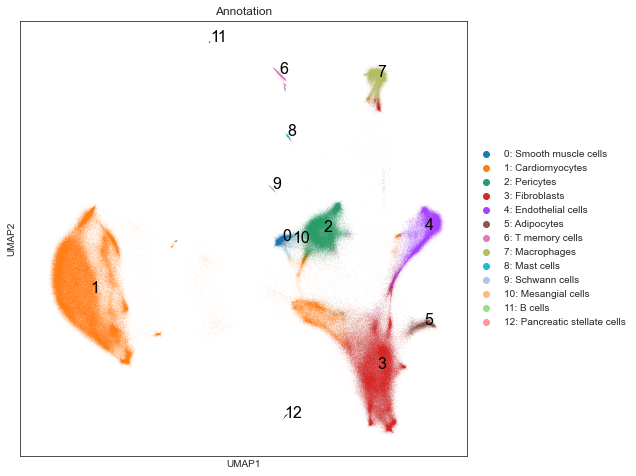

0.818
0.739


In [8]:
##visualization
adata.obs['Annotation']=annotation
#embedding = umap.UMAP(n_neighbors=10,min_dist=0.0,n_components=2,
#                      metric='correlation').fit_transform(scores.values)

down_samp = pd.DataFrame(scores.values)
down_samp = down_samp.sample(frac=0.15)
umaps = umap.UMAP(n_neighbors=10, min_dist=0.0, n_components=2,
                  metric="correlation").fit(down_samp.values)
embedding = umaps.transform(scores.values)

embedding = pd.DataFrame(embedding)
embedding.columns=['UMAP1','UMAP2']
adata.obsm['X_umap'] = embedding.iloc[:,:2].values

#sc.pl.umap(adata, color=["Annotation"],ncols=1)
plot_ann_umap(ad=adata,ann=annotation)

print(round(adjusted_rand_score(adata.obs['CellType'],np.array(annotation)),3))
print(round(normalized_mutual_info_score(adata.obs['CellType'],np.array(annotation)),3))

... storing 'Annotation' as categorical
... storing 'groups' as categorical


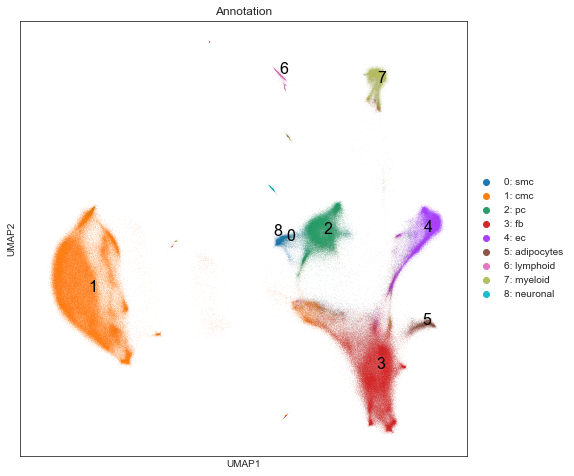

In [9]:
##Authors' annotation
plot_ann_umap(ad=adata,ann=adata.obs['CellType'])